In [609]:
from math import *
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [610]:
robotPose = [[0, 50, 0],
             [-40, 40, 0],
             [-50, 0, 0],
             [-40, -40, 0],
             [0, -50, 0]]
goalPose = [0, 0, pi]
parameters = {
    'Krho':3, 'Kalpha':6, 'Kbeta':-1.5,
    'backwardAllowed': False,
    'useConstantSpeed': True,
    'constantSpeed':.4
}
dt = 1

In [611]:
def normalizeAngle(angle):
    """
    set angle to the range [-pi, pi)
    """
    return (angle + pi) % (2*pi) - pi

In [612]:
def calculateControlOutput(robotPose, goalPose, parameters):
    """
    This computes the motor velocities for a differential driven robot
    """
    x = robotPose[0]
    y = robotPose[1]
    theta = robotPose[2]
    
    xg = goalPose[0]
    yg = goalPose[1]
    thetag = goalPose[2]
    
    rho = sqrt((xg-x)**2 + (yg-y)**2)
    gamma = atan2(yg-y, xg-x)
    alpha = gamma - theta
    alpha = normalizeAngle(alpha)
    
    Kalpha = parameters['Kalpha']
    Kbeta = parameters['Kbeta']
    Krho = parameters['Krho']
    
    beta = thetag - theta - alpha
    beta = normalizeAngle(beta)
    
    v = Krho * rho
    w = Kalpha*alpha + Kbeta*beta
    
    if parameters['backwardAllowed']:
        # two case
        # case1: goal point is in front of robot
        # case2: goal point is behind robot
        if abs(alpha) <= pi/2:
            # in front of robot
            # nothing to do
            pass
        else:
            # behind robot
            alpha = gamma - theta - pi
            alpha = normalizeAngle(alpha)
            beta = thetag - gamma - pi
            v = -Krho * rho
            w = Kalpha*alpha + Kbeta*beta

    if parameters['useConstantSpeed']:
        tol = 1e-6
        absVel = abs(v)
        if absVel > parameters['constantSpeed']:
            v = v/absVel*parameters['constantSpeed']
            w = w/absVel*parameters['constantSpeed']
    
    return v, w

In [613]:
results = []
for robotPose_ in robotPose:
    results_ = []
    results_.append(robotPose_[:-1])
    iterate = 0
    while True:
        iterate += 1
        v, w = calculateControlOutput(robotPose_, goalPose, parameters)
        theta = robotPose_[2] + w*dt
        theta = normalizeAngle(theta)
        xd = v * cos(theta) * dt
        yd = v * sin(theta) * dt

        robotPose_[0] += xd
        robotPose_[1] += yd
        robotPose_[2] = theta

        results_.append(robotPose_[:-1])
#          print(f"{iterate}: v:{v:.2f}, w:{w:.2f}, \
#     pose: [{robotPose[0]:.2f}, {robotPose[1]:.2f}, {robotPose[2]:.3f}]")

        rho = sqrt((goalPose[0]-robotPose_[0])**2 + (goalPose[1] - robotPose_[1])**2)
        if rho < 0.4:
            break
    results.append(results_)

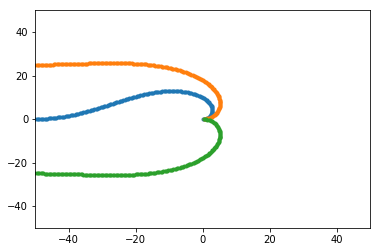

In [608]:
fig = plt.figure()
for result in results:
    r = np.array(result)
    plt.xlim(-50, 50)
    plt.ylim(-50, 50)
    plt.plot(r[:,0], r[:,1], '.')
plt.show()